# DATA

In [1]:
import numpy as np
import pandas as pd
import sklearn
import os
import pickle
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy.stats import norm


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  
tf.random.set_seed(1234)

In [2]:
data = pd.read_csv('data/final_data.csv')
data.head()

,r,sigma,T,s0,k,t,asset,call,asset_greater_call,scaled_call,scaled_asset,tau,moneyness,d1,d2,delta,gamma,theta,vega,rho
0,0.05,0.05,0.1,10.0,10.0,0.0,10.000000,0.090978,True,0.009098,1.0,0.10,1.000000,0.324133,0.308322,0.627082,2.394010,-0.608243,1.197005,0.617984
1,0.05,0.05,0.1,10.0,10.0,1.0,9.977024,0.071240,True,0.007124,1.0,0.09,0.997702,0.154153,0.139153,0.561255,2.634254,-0.604191,1.179973,0.497558
2,0.05,0.05,0.1,10.0,10.0,2.0,9.979236,0.066344,True,0.006634,1.0,0.08,0.997924,0.142939,0.128797,0.556831,2.798086,-0.622830,1.114591,0.439232
3,0.05,0.05,0.1,10.0,10.0,3.0,10.085137,0.133263,True,0.013326,1.0,0.07,1.008514,0.912040,0.898811,0.819126,1.972797,-0.657203,0.702286,0.568942
4,0.05,0.05,0.1,10.0,10.0,4.0,9.964273,0.045868,True,0.004587,1.0,0.06,0.996427,-0.041160,-0.053407,0.483584,3.266261,-0.644005,0.972889,0.286362


In [3]:
scaler = StandardScaler()
X = data[['r','sigma','tau','k','asset']]
y = data['call']
#X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

# NEURAL NET MODEL

In [4]:
from keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.initializers import RandomUniform, GlorotUniform, HeUniform
from keras.models import model_from_json
from keras import backend as K
import tensorflow_addons as tfa
from tensorflow import GradientTape

In [5]:
def create_model(activation, lr_0, batch_norm, dropout_rate, layer_number, neuron_number,\
                neuron_decrease, data_length, initializer):
    opt = Adam(learning_rate = lr_0)
    model = Sequential()
    model.add(Dense(neuron_number, input_shape=(5,), activation = activation, \
                    kernel_initializer=initializer , bias_initializer=initializer))
    for i in range(layer_number):
        if batch_norm == True:
            model.add(BatchNormalization())         
        neuron_number = int(neuron_number/neuron_decrease)
        model.add(Dense(neuron_number, activation = activation))
    if batch_norm == True:
        model.add(BatchNormalization()) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, name='Final_1D_output', activation = activation))
    model.compile(optimizer=opt,loss='mean_squared_error',\
                  metrics=[tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))],\
                 run_eagerly=True)
    print(model.summary())
    return model

def callback_list(patience):
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    return early_stop

def plot_loss(loss,val_loss):    
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

def plot_metr(metr,val_metr,name):
    plt.figure()
    plt.plot(metr)
    plt.plot(val_metr)
    plt.title('Model'+str(name))
    plt.ylabel(str(name))
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show() 

In [6]:
patience_f = 2
callbacks = callback_list(patience=patience_f)

# HYPERPARAMETER TUNED MODEL

## Result from RandomSearch

In [7]:
# load json and create model
json_file_hyper = open('results/model_greeks.json', 'r')
model_hyper = json_file_hyper.read()
json_file_hyper.close()
final_model = model_from_json(model_hyper)
# load weights into new model
final_model.load_weights("results/model_greeks.h5")
print("Loaded model from disk")

Metal device set to: Apple M1 Pro
Loaded model from disk


In [8]:
final_hist = pd.read_csv('results/train_hist_greeks.csv')
final_hist

,loss,r_square,val_loss,val_r_square
0,2.411919,0.948854,0.257884,0.994612
1,0.131595,0.997209,0.057438,0.998800
2,0.062123,0.998683,0.031128,0.999350
3,0.040006,0.999152,0.043548,0.999090
4,0.030624,0.999351,0.033913,0.999291


In [9]:
# HYPERPARAMETER TUNING
a_file = open("results/search_params_greeks.pkl", "rb")
output = pickle.load(a_file)
print(output)
a_file.close()

{'neuron_number': 512, 'neuron_decrease': 2, 'lr_0': 0.001, 'layer_number': 3, 'initializer': <keras.initializers.initializers_v2.RandomUniform object at 0x16c4ccb50>, 'dropout_rate': 0.0, 'data_length': 1000000, 'batch_size': 2048, 'batch_norm': False, 'activation': 'relu'}


In [10]:
final_model_arch = create_model(activation = output['activation'], lr_0 = output['lr_0'], \
                                 batch_norm = output['batch_norm'], dropout_rate = output['dropout_rate'], \
                                 layer_number = output['layer_number'], neuron_number = output['neuron_number'], \
                                    data_length = output['data_length'], neuron_decrease = output['neuron_decrease'],\
                                 initializer = output['initializer'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               3072      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Final_1D_output (Dense)     (None, 1)                 65        
                                                                 
Total params: 175,617
Trainable params: 175,617
Non-trai

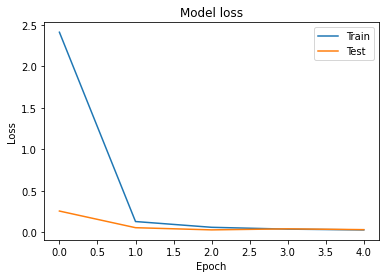

In [11]:
plot_loss(final_hist['loss'], final_hist['val_loss'])

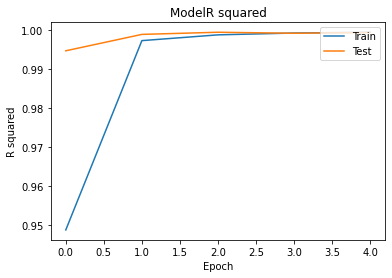

In [12]:
plot_metr(final_hist['r_square'], \
          final_hist['val_r_square'], 'R squared')

## Extra fine-tuning

In [13]:
sklearn_model = KerasRegressor(build_fn = create_model)

params = dict(activation=[output['activation']],lr_0 = [output['lr_0']], batch_norm=[True, False], \
              dropout_rate = [0.0,0.1], layer_number = [output['layer_number']],\
              neuron_decrease = [output['neuron_decrease']], neuron_number = [output['neuron_number']], \
              data_length = [output['data_length']], batch_size = [output['batch_size']], \
              initializer = [output['initializer']] )

len(ParameterGrid(params))

/var/folders/tj/wl79cq5x32dccj6j6xcb41r80000gn/T/ipykernel_28132/945307363.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = KerasRegressor(build_fn = create_model)


4

In [14]:
grid_search = GridSearchCV(sklearn_model, param_grid=params, cv=10, verbose=3) 

In [15]:
start = datetime.now()
grid_search_results = grid_search.fit(X_train,y_train,callbacks=[callbacks],validation_split=0.2,\
                                         epochs = 50)
end = datetime.now()
total_time = (end-start).total_seconds()
print(total_time)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               3072      
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                           

2022-05-08 10:20:40.902511: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


282/282 [==============================] - 9s 32ms/step - loss: 2.8551 - r_square: 0.9395 - val_loss: 9.1143 - val_r_square: 0.8100
Epoch 2/50
282/282 [==============================] - 9s 32ms/step - loss: 0.4333 - r_square: 0.9908 - val_loss: 1.3505 - val_r_square: 0.9718
Epoch 3/50
282/282 [==============================] - 9s 31ms/step - loss: 0.2977 - r_square: 0.9937 - val_loss: 0.3256 - val_r_square: 0.9932
Epoch 4/50
282/282 [==============================] - 9s 32ms/step - loss: 0.2387 - r_square: 0.9949 - val_loss: 0.0875 - val_r_square: 0.9982
Epoch 5/50
282/282 [==============================] - 9s 31ms/step - loss: 0.2080 - r_square: 0.9956 - val_loss: 0.0518 - val_r_square: 0.9989
Epoch 6/50
282/282 [==============================] - 9s 32ms/step - loss: 0.1645 - r_square: 0.9965 - val_loss: 0.1085 - val_r_square: 0.9977
Epoch 7/50
282/282 [==============================] - 9s 31ms/step - loss: 0.1633 - r_square: 0.9965 - val_loss: 0.0348 - val_r_square: 0.9993
Epoch 8/50

40/40 [==============================] - 0s 10ms/step - loss: 0.0658 - r_square: 0.9986
[CV 3/10] END activation=relu, batch_norm=True, batch_size=2048, data_length=1000000, dropout_rate=0.0, initializer=<keras.initializers.initializers_v2.RandomUniform object at 0x16c4ccb50>, layer_number=3, lr_0=0.001, neuron_decrease=2, neuron_number=512;, score=-0.066 total time= 1.1min
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               3072      
                                                                 
 batch_normalization_12 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 batch_

 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_22 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_23 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 Final_1D_output (Dense)     (None, 1)                 65        
          

                                                                 
Total params: 179,457
Trainable params: 177,537
Non-trainable params: 1,920
_________________________________________________________________
None
Epoch 1/50
282/282 [==============================] - 9s 33ms/step - loss: 1.6989 - r_square: 0.9638 - val_loss: 5.2097 - val_r_square: 0.8914
Epoch 2/50
282/282 [==============================] - 9s 33ms/step - loss: 0.3905 - r_square: 0.9917 - val_loss: 1.7750 - val_r_square: 0.9630
Epoch 3/50
282/282 [==============================] - 9s 33ms/step - loss: 0.2542 - r_square: 0.9946 - val_loss: 0.2924 - val_r_square: 0.9939
Epoch 4/50
282/282 [==============================] - 9s 32ms/step - loss: 0.2053 - r_square: 0.9956 - val_loss: 0.1782 - val_r_square: 0.9963
Epoch 5/50
282/282 [==============================] - 9s 32ms/step - loss: 0.1647 - r_square: 0.9965 - val_loss: 0.1124 - val_r_square: 0.9977
Epoch 6/50
282/282 [==============================] - 9s 32ms/step - los

Epoch 4/50
282/282 [==============================] - 9s 34ms/step - loss: 0.1957 - r_square: 0.9958 - val_loss: 0.1829 - val_r_square: 0.9961
Epoch 5/50
40/40 [==============================] - 0s 10ms/step - loss: 0.1695 - r_square: 0.9966
[CV 10/10] END activation=relu, batch_norm=True, batch_size=2048, data_length=1000000, dropout_rate=0.0, initializer=<keras.initializers.initializers_v2.RandomUniform object at 0x16c4ccb50>, layer_number=3, lr_0=0.001, neuron_decrease=2, neuron_number=512;, score=-0.170 total time=  47.1s
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 512)               3072      
                                                                 
 batch_normalization_40 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                 

 dense_54 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_50 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_51 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 Final_1D_output (Dense)     (None, 1)                 65        
                                                                 
Total params: 179,457
Trainable params: 177,537
Non-trainable params: 1,920


Epoch 4/50
282/282 [==============================] - 16s 57ms/step - loss: 0.5550 - r_square: 0.9883 - val_loss: 0.3826 - val_r_square: 0.9920
Epoch 5/50
282/282 [==============================] - 16s 58ms/step - loss: 0.5005 - r_square: 0.9894 - val_loss: 0.0683 - val_r_square: 0.9986
Epoch 6/50
282/282 [==============================] - 17s 59ms/step - loss: 0.5389 - r_square: 0.9886 - val_loss: 0.1349 - val_r_square: 0.9972
Epoch 7/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0641 - r_square: 0.9986
[CV 5/10] END activation=relu, batch_norm=True, batch_size=2048, data_length=1000000, dropout_rate=0.1, initializer=<keras.initializers.initializers_v2.RandomUniform object at 0x16c4ccb50>, layer_number=3, lr_0=0.001, neuron_decrease=2, neuron_number=512;, score=-0.064 total time= 2.0min
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)        

 batch_normalization_68 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_73 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_69 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_74 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_70 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_75 (Dense)            (None, 64)                8256      
                                                                 
 batch_nor

                                                                 
 Final_1D_output (Dense)     (None, 1)                 65        
                                                                 
Total params: 179,457
Trainable params: 177,537
Non-trainable params: 1,920
_________________________________________________________________
None
Epoch 1/50
282/282 [==============================] - 27s 93ms/step - loss: 3.0046 - r_square: 0.9358 - val_loss: 4.7475 - val_r_square: 0.8999
Epoch 2/50
282/282 [==============================] - 26s 91ms/step - loss: 0.7380 - r_square: 0.9842 - val_loss: 1.1136 - val_r_square: 0.9765
Epoch 3/50
282/282 [==============================] - 29s 104ms/step - loss: 0.6244 - r_square: 0.9867 - val_loss: 1.1887 - val_r_square: 0.9749
Epoch 4/50
282/282 [==============================] - 33s 116ms/step - loss: 0.5653 - r_square: 0.9879 - val_loss: 0.5710 - val_r_square: 0.9880
Epoch 5/50
282/282 [==============================] - 33s 116ms/step - loss: 

None
Epoch 1/50
282/282 [==============================] - 7s 25ms/step - loss: 2.5897 - r_square: 0.9452 - val_loss: 0.3112 - val_r_square: 0.9935
Epoch 2/50
282/282 [==============================] - 5s 19ms/step - loss: 0.2580 - r_square: 0.9945 - val_loss: 0.1618 - val_r_square: 0.9966
Epoch 3/50
282/282 [==============================] - 5s 18ms/step - loss: 0.0759 - r_square: 0.9984 - val_loss: 0.0730 - val_r_square: 0.9985
Epoch 4/50
282/282 [==============================] - 5s 19ms/step - loss: 0.0498 - r_square: 0.9989 - val_loss: 0.0221 - val_r_square: 0.9995
Epoch 5/50
282/282 [==============================] - 6s 20ms/step - loss: 0.0353 - r_square: 0.9993 - val_loss: 0.0279 - val_r_square: 0.9994
Epoch 6/50
282/282 [==============================] - 6s 20ms/step - loss: 0.0286 - r_square: 0.9994 - val_loss: 0.0135 - val_r_square: 0.9997
Epoch 7/50
282/282 [==============================] - 6s 20ms/step - loss: 0.0254 - r_square: 0.9995 - val_loss: 0.0209 - val_r_square: 0

282/282 [==============================] - 5s 18ms/step - loss: 0.0988 - r_square: 0.9979 - val_loss: 0.0392 - val_r_square: 0.9992
Epoch 4/50
282/282 [==============================] - 5s 17ms/step - loss: 0.0472 - r_square: 0.9990 - val_loss: 0.0465 - val_r_square: 0.9990
Epoch 5/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0397 - r_square: 0.9992
[CV 6/10] END activation=relu, batch_norm=False, batch_size=2048, data_length=1000000, dropout_rate=0.0, initializer=<keras.initializers.initializers_v2.RandomUniform object at 0x16c4ccb50>, layer_number=3, lr_0=0.001, neuron_decrease=2, neuron_number=512;, score=-0.040 total time=  27.1s
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 512)               3072      
                                                                 
 dense_109 (Dense)           (None, 256)         

 dense_122 (Dense)           (None, 128)               32896     
                                                                 
 dense_123 (Dense)           (None, 64)                8256      
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 Final_1D_output (Dense)     (None, 1)                 65        
                                                                 
Total params: 175,617
Trainable params: 175,617
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
282/282 [==============================] - 6s 20ms/step - loss: 2.7301 - r_square: 0.9417 - val_loss: 0.3461 - val_r_square: 0.9927
Epoch 2/50
282/282 [==============================] - 5s 17ms/step - loss: 0.2330 - r_square: 0.9950 - val_loss: 0.0822 - val_r_square: 0.9983
Epoch 3/50
282/282 [=======================

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 512)               3072      
                                                                 
 dense_133 (Dense)           (None, 256)               131328    
                                                                 
 dense_134 (Dense)           (None, 128)               32896     
                                                                 
 dense_135 (Dense)           (None, 64)                8256      
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 Final_1D_output (Dense)     (None, 1)                 65        
                                                                 
Total params: 175,617
Trainable params: 175,617
Non-t

Epoch 7/50
40/40 [==============================] - 1s 21ms/step - loss: 0.0350 - r_square: 0.9992
[CV 5/10] END activation=relu, batch_norm=False, batch_size=2048, data_length=1000000, dropout_rate=0.1, initializer=<keras.initializers.initializers_v2.RandomUniform object at 0x16c4ccb50>, layer_number=3, lr_0=0.001, neuron_decrease=2, neuron_number=512;, score=-0.035 total time= 4.1min
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 512)               3072      
                                                                 
 dense_145 (Dense)           (None, 256)               131328    
                                                                 
 dense_146 (Dense)           (None, 128)               32896     
                                                                 
 dense_147 (Dense)           (None, 64)                8256 

282/282 [==============================] - 51s 179ms/step - loss: 0.2675 - r_square: 0.9943 - val_loss: 0.0253 - val_r_square: 0.9995
Epoch 9/50
40/40 [==============================] - 1s 27ms/step - loss: 0.0252 - r_square: 0.9995
[CV 8/10] END activation=relu, batch_norm=False, batch_size=2048, data_length=1000000, dropout_rate=0.1, initializer=<keras.initializers.initializers_v2.RandomUniform object at 0x16c4ccb50>, layer_number=3, lr_0=0.001, neuron_decrease=2, neuron_number=512;, score=-0.025 total time= 6.4min
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 512)               3072      
                                                                 
 dense_157 (Dense)           (None, 256)               131328    
                                                                 
 dense_158 (Dense)           (None, 128)               328

Epoch 8/50
313/313 [==============================] - 10s 31ms/step - loss: 0.1339 - r_square: 0.9972 - val_loss: 0.0830 - val_r_square: 0.9983
Epoch 9/50
313/313 [==============================] - 10s 32ms/step - loss: 0.1141 - r_square: 0.9976 - val_loss: 0.1158 - val_r_square: 0.9976
5319.618263


In [16]:
# serialize model to JSON
model_json_test = grid_search_results.best_estimator_.model.to_json()
with open("results/grid_results_greeks/model_extra_greeks.json", "w") as json_file:
    json_file.write(model_json_test)
# serialize weights to HDF5
grid_search_results.best_estimator_.model.save_weights("results/grid_results_greeks/model_extra_greeks.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
import pickle
search_params_test = grid_search_results.best_params_

a_file_test = open("results/grid_results_greeks/search_params_extra_greeks.pkl", "wb")
pickle.dump(search_params_test, a_file_test)
a_file_test.close()

In [18]:
model_hist_test = grid_search_results.best_estimator_.model.history
train_hist_test = pd.DataFrame(model_hist_test.history)
train_hist_test.to_csv('results/grid_results_greeks/train_hist_extra_greeks.csv', index=False)